In [2154]:
# FONCTIONNE COMPLETEMENT AU 02/04/2016
from datetime import date

from openfisca_france import init_country
from openfisca_france.model.base import *

# to debug / trace
from openfisca_core import web_tools

# Système socio-fiscal

In [2155]:
TaxBenefitSystem = init_country()
tax_benefit_system = TaxBenefitSystem()

In [2156]:
from openfisca_core import reforms

In [2157]:
ReformeRevenuDeBase = reforms.make_reform(
    key = 'reforme_rdb',
    name = u"Réforme Revenu de base",
    reference = tax_benefit_system,
    )

# Réforme : 1. Revenu de base

In [2158]:
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_
#- Hausse de la CSG déductible au taux de 25%
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire
#- Intégrer le revenu de base au revenu disponible
#- Mise en place d'un crédit d'impot familles monoparentales montant ??? (50€)
#- Supprimer le RSA


#-Visualisation graphique en abscisse salaire brut et en ordonnée variation du revenu disponible 
# pour un célibataire sans enfant
# pour un couple sans enfant
# une famille monoparentale


#(- Nouveau calcul de l'IRPP)


In [2159]:
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
import json
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
def modify_legislation_json(reference_legislation_json_copy):
    for value_json in reference_legislation_json_copy['children']['csg']['children']['activite']['children']['deductible']['children']['taux']['values']:
        value_json['value'] = 0.20
    return reference_legislation_json_copy



In [2160]:
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire

class rdb(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age') 
        rmi = simulation.legislation_at(period.start).minim.rmi
        
        return period, ((age >= 18) * rmi.rmi * ( 1 -rmi.forfait_logement.taux1) + not_(age >= 18) * 0)



In [2161]:
#- Intégrer le revenu de base au revenu disponible
class revdisp(ReformeRevenuDeBase.Variable):
    reference = Menages.column_by_name['revdisp']

    def function(self, simulation, period):
        '''
        Revenu disponible - ménage
        'men'
        '''
        period = period.start.period('year').offset('first-of')
        rev_trav_holder = simulation.compute('rev_trav', period)
        pen_holder = simulation.compute('pen', period)
        rev_cap_holder = simulation.compute('rev_cap', period)
        psoc_holder = simulation.compute('psoc', period)
        ppe_holder = simulation.compute('ppe', period)
        impo = simulation.calculate('impo', period)
        rdb_holder = simulation.calculate_add('rdb', period)
        credit_impot_monoparentales_holder = simulation.calculate_add('credit_impot_monoparentales', period)

        pen = self.sum_by_entity(pen_holder)
        ppe = self.cast_from_entity_to_role(ppe_holder, role = VOUS)
        ppe = self.sum_by_entity(ppe)
        psoc = self.cast_from_entity_to_role(psoc_holder, role = CHEF)
        psoc = self.sum_by_entity(psoc)
        rev_cap = self.sum_by_entity(rev_cap_holder)
        rev_trav = self.sum_by_entity(rev_trav_holder)
        rdb = self.sum_by_entity(rdb_holder)
        #credit_impot_monoparentales = self.sum_by_entity(credit_impot_monoparentales_holder)
        
        return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_monoparentales_holder

In [2162]:
#- Mise en place d'un crédit d'impot familles monoparentales montant (150€)
class credit_impot_monoparentales(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Menages
    label = u"credit_impot_monoparentales"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        nb_enf_a_charge = simulation.calculate('nombre_enfants_a_charge_menage',period)
        caseT = simulation.calculate('caseT',period) #Egal True si le parent est isolé
      
        
        #return period, or_(and_(age_holder >= 18, nb_enf_a_charge > 0, caseT), or_(age_holder < 18, nb_enf_a_charge <= 0, not_(caseT)) * 0) * 100
        return period, (nb_enf_a_charge > 0) * (caseT) * 150
    #Si le parent est isolé, avec au moins un enfant, et qu'il est majeur il reçoit la pension

In [2163]:
#- Supprimer le RSA
class rsa_socle(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['rsa_socle']

    def function(self, simulation, period):
        period = period.this_month
        nb_par = simulation.calculate('nb_par', period)
        eligib = simulation.calculate('rsa_eligibilite', period)
        nb_enfant_rsa = simulation.calculate('nb_enfant_rsa', period)
        rmi = simulation.legislation_at(period.start).minim.rmi

        nbp = nb_par + nb_enfant_rsa

        taux = (
            1 +
            (nbp >= 2) * rmi.txp2 +
            (nbp >= 3) * rmi.txp3 +
            (nbp >= 4) * ((nb_par == 1) * rmi.txps + (nb_par != 1) * rmi.txp3) +
            max_(nbp - 4, 0) * rmi.txps
        )
        #on met à zéro
        return period, eligib * rmi.rmi * taux * 0

# Tests

In [2164]:
reform = ReformeRevenuDeBase()
reform.modify_legislation_json(modifier_function = modify_legislation_json)

# Individu seul

In [2165]:
parent1_salaire_de_base = 20000

In [2166]:
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    )
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [2167]:
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    )
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

Calculs de référence (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [2168]:
simulation_ref_individu_seul.calculate('revdisp')

array([ 16667.44140625], dtype=float32)

In [2169]:
simulation_ref_individu_seul.calculate('irpp')

array([-231.078125], dtype=float32)

In [2170]:
simulation_ref_individu_seul.calculate_add('rsa')

array([ 558.21966553], dtype=float32)

In [2171]:
simulation_ref_individu_seul.calculate('csg_imposable_salaire')

array([-471.59909058], dtype=float32)

In [2172]:
simulation_ref_individu_seul.calculate('csg_deductible_salaire')

array([-1002.14794922], dtype=float32)

In [2173]:
simulation_ref_individu_seul.calculate('tot_impot')

array([ 1805.86608887], dtype=float32)

Calculs avec réforme RDB (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [2174]:
simulation_rdb_individu_seul.calculate('revdisp')

array([ 18567.88476562], dtype=float32)

In [2175]:
simulation_rdb_individu_seul.calculate('irpp')

array([ 0.], dtype=float32)

In [2176]:
simulation_rdb_individu_seul.calculate('csg_imposable_salaire')

array([-471.59909058], dtype=float32)

In [2177]:
simulation_rdb_individu_seul.calculate('csg_deductible_salaire')

array([-3929.99145508], dtype=float32)

In [2178]:
simulation_rdb_individu_seul.calculate('tot_impot')

array([ 4499.84033203], dtype=float32)

In [2179]:
# trace
simulation_rdb_individu_seul.calculate('tot_impot')
#print web_tools.get_trace_tool_link(scenario, ['tot_impot'])

array([ 4499.84033203], dtype=float32)

In [2180]:
simulation_rdb_individu_seul.calculate('rdb')

array([ 5307.87841797], dtype=float32)

## Graphiques: scenario variant selon salaire_de_base (0 => 60k par palier de 5k)

In [2110]:
min_salaire_de_base = 0
max_salaire_de_base = 60000
nb_palier = max_salaire_de_base / 5000

In [2111]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2112]:
# REFERENCE
year = 2014
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = year,
    parent1 = dict(
        birth = date(1980, 1, 1),
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
)
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [2113]:
# RDB
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = year,
    parent1 = dict(
        birth = date(1980, 1, 1),
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
    )
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

In [2114]:
salaire_de_base = simulation_ref_individu_seul.calculate("salaire_de_base")
print salaire_de_base

[     0.           5454.54541016  10909.09082031  16363.63671875
  21818.18164062  27272.7265625   32727.2734375   38181.81640625
  43636.36328125  49090.91015625  54545.453125    60000.        ]


In [2115]:
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_ref = simulation_ref_individu_seul.calculate_add("revdisp")
print revenu_disponible_ref
revenu_disponible_rdb = simulation_rdb_individu_seul.calculate_add("revdisp")
print revenu_disponible_rdb

[  5185.51025391   7107.81005859  10697.53515625  14287.2578125
  17057.49023438  20649.50976562  24508.18164062  28209.32421875
  31499.9375      34790.25390625  38080.8671875   41371.484375  ]
[  5307.87841797   7253.68457031  11636.42578125  16019.14257812
  19773.32226562  22681.22070312  25628.72265625  28801.93359375
  32043.68945312  34852.1484375   37559.828125    40267.47265625]


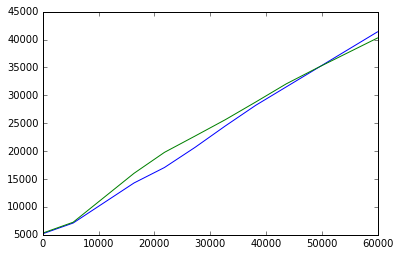

In [2116]:
plt.plot(salaire_de_base[::1], revenu_disponible_ref, salaire_de_base[::1], revenu_disponible_rdb)

# Couples sans enfants
On fait varier le salaire d'un des deux, l'autre est fixé à 0.

In [2144]:
def make_two_parents_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = 60000, count = 13):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            birth = date(1980, 1, 1),
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation = 4,
            ),
        )
    return scenario

In [2145]:
scenario_alone_ref = make_two_parents_scenario(0, 2014)
simulation_alone_ref = scenario_alone_ref.new_simulation()

In [2147]:
scenario_alone_reform = make_two_parents_scenario(0, 2014, reform)
simulation_alone_reform = scenario_alone_reform.new_simulation()

[  7973.95898438   9896.2578125   13441.17773438  16880.01367188  19438.75
  21681.51757812  24508.18164062  28209.32421875  31499.9375
  34790.25390625  38080.8671875   41371.484375  ]
[     0.              0.           5454.54541016      0.          10909.09082031
      0.          16363.63671875      0.          21818.18164062      0.
  27272.7265625       0.          32727.2734375       0.          38181.81640625
      0.          43636.36328125      0.          49090.91015625      0.
  54545.453125        0.          60000.              0.        ]


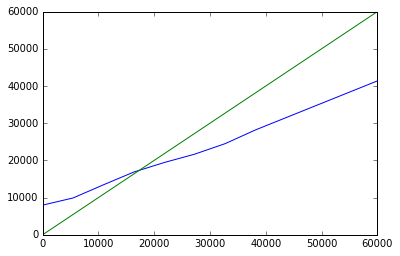

In [2149]:
revenu_disponible_couple_ref = simulation_alone_ref.calculate_add("revdisp")
print revenu_disponible_couple_ref
revenu_disponible_couple_rdb = simulation_alone_reform.calculate_add("revdisp")
salaire_de_base_couple_ref = simulation_alone_ref.calculate("salaire_de_base")
salaire_de_base_couple = simulation_alone_reform.calculate("salaire_de_base")
print salaire_de_base_couple
salaire_de_base_couple_bis = salaire_de_base_couple[0::2]
salaire_de_base_couple_ref_bis = salaire_de_base_couple_ref[0::2]
plt.plot(salaire_de_base_couple_bis[::1], revenu_disponible_couple_ref, salaire_de_base_couple_bis[::1], salaire_de_base_couple_bis)